# H9.2  C-SVM with standard parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
%matplotlib inline

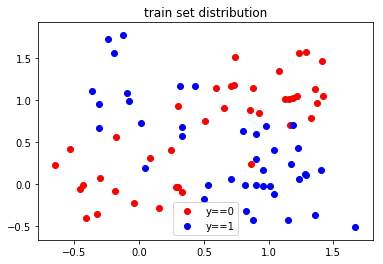

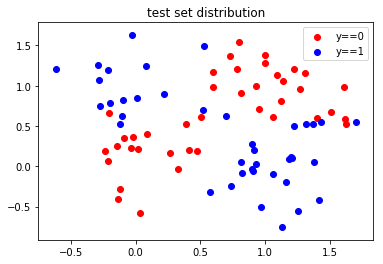

In [2]:
def SampleMixtureNormal2D(m1, s1, m2, s2): 
    # m1, m2 are the means, s1, s2 the variances 
    if (np.random.choice([0,1])):
        return np.random.multivariate_normal(m1, [[s1, 0], [0, s1]])
    else:
        return np.random.multivariate_normal(m2, [[s2, 0], [0, s2]])

def getSamples(m1, m2, m3, m4, s, N = 0, M = 0):
    samples = np.zeros((N + M, 2))
    labels = np.zeros(N + M)
    for i in range(N):
        samples[i] = SampleMixtureNormal2D(m1, s, m2, s)
        labels[i] = 1
    for i in range(M):
        samples[i + N] = SampleMixtureNormal2D(m3, s, m4, s)
        labels[i + N] = 0
    return samples, labels

train_input, train_labels = getSamples([0, 1], [1, 0], [0, 0], [1, 1], 0.1, 40, 40)
test_input, test_labels = getSamples([0, 1], [1, 0], [0, 0], [1, 1], 0.1, 40, 40)

# print train_input=

plt.scatter((train_input[train_labels==0])[:, 0], (train_input[train_labels==0])[:, 1],color='red', label='y==0')
plt.scatter((train_input[train_labels==1])[:, 0],(train_input[train_labels==1])[:, 1], color='b', label='y==1')
plt.legend()
plt.title('train set distribution')
plt.show()

plt.scatter((test_input[test_labels==0])[:, 0], (test_input[test_labels==0])[:, 1],color='red', label='y==0')
plt.scatter((test_input[test_labels==1])[:, 0],(test_input[test_labels==1])[:, 1], color='b', label='y==1')
plt.legend()
plt.title('test set distribution')
plt.show()

In [76]:
def svm_predict(train_input, train_labels, c_p=1.0, gamma_p='auto'):
    svc = svm.SVC(C = c_p, gamma=gamma_p).fit(train_input, train_labels)
    pred_labels = svc.predict(test_input)
    sv = svc.support_vectors_
    acc = sum(pred_labels == test_labels) * 1.0 / len(test_labels)
    return svc, acc

def draw_decision_boundary(svc, test_input, test_label, title):
    h = .01  # step size in the mesh
    # create a mesh to plot in
    SV = svc.support_vectors_
    x_min, x_max = test_input[:, 0].min() - 1, test_input[:, 0].max() + 1
    y_min, y_max = test_input[:, 1].min() - 1, test_input[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)
    plt.scatter((test_input[test_labels==0])[:, 0], (test_input[test_labels==0])[:, 1],color='red', label='y==0')
    plt.scatter((test_input[test_labels==1])[:, 0],(test_input[test_labels==1])[:, 1], color='b', label='y==1')
    plt.scatter(SV[:,0], SV[:, 1], color='green', label='SV')
    plt.legend()
    plt.title(title)
    plt.show()

SVM with standard parameters using RBF kernel: acc is 0.862500, num of SVs: 51


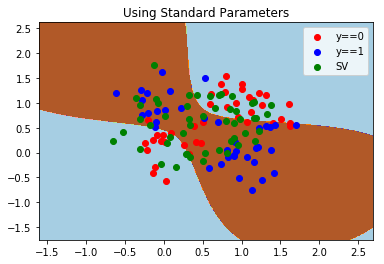

In [90]:
svc_with_standard_params, acc=svm_predict(train_input, train_labels)
print ("SVM with standard parameters using RBF kernel: acc is %f, num of SVs: %d" % 
       (acc, len(svc_with_standard_params.support_vectors_)))
draw_decision_boundary(svc_with_standard_params, test_input, test_labels, 'Using Standard Parameters')

# H9.3: C-SVM parameter optimization

## a

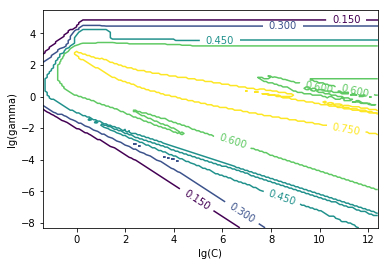

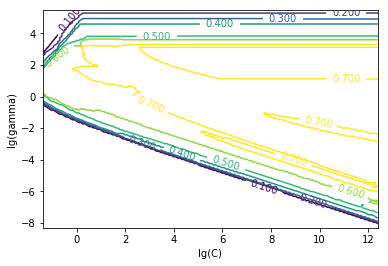

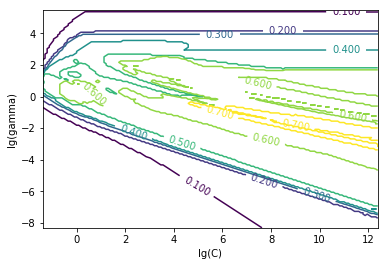

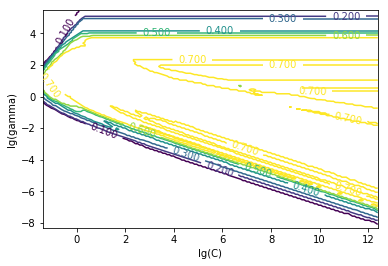

Optimal (C, gamma) is (240387.107902, 22.627417), accuracy is 0.800000


In [16]:
NC, N_gamma, C0, gamma0, q = 160, 160, 2**-2, 2**-12, 2**0.125
C_options = np.empty((NC,))
C_options[0] = C0
C_options[1:] = q
C_options = np.cumprod(C_options)
gamma_options = np.empty((N_gamma,))
gamma_options[0] = gamma0
gamma_options[1:] = q
gamma_options = np.cumprod(gamma_options)
C, gamma = np.meshgrid(C_options, gamma_options)
params = np.array(zip(C.flatten(), gamma.flatten()))

fold = 4
fold_length = len(train_labels)/fold
kf = KFold(n_splits=fold)
kf.get_n_splits(train_input)
optimal_params = params[0,:]
best_acc = 0.0

def calc_acc(test_labels, pred_labels):
    acc = sum(pred_labels == test_labels) * 1.0 / len(test_labels)
    return acc

for train_index, test_index in kf.split(train_input):
    acc = np.zeros(len(params))
    j = 0
    for param in params:
        # train
        svc = svm.SVC(C=param[0], gamma=param[1]).fit(train_input[train_index], train_labels[train_index])
        pred_labels = svc.predict(train_input[test_index])
        # predict
        acc[j] = calc_acc(train_labels[test_index], pred_labels)
        if(acc[j] == acc.max()):
            optimal_params = param
            best_acc = acc[j]
        j += 1
    acc = acc.reshape(C.shape)
    CS = plt.contour(np.log(C), np.log(gamma),acc)
    plt.clabel(CS, inline=1)
    plt.xlabel('lg(C)')
    plt.ylabel('lg(gamma)')
    plt.show()
print ("Optimal (C, gamma) is (%f, %f), accuracy is %f" % (optimal_params[0], optimal_params[1], best_acc))


## b

In [88]:
svc_with_optimal_params, acc = svm_predict(train_input, train_labels, c_p=optimal_params[0], gamma_p=optimal_params[1])
print ("SVM with optimal parameters using RBF kernel: acc is %f, num of SVs: %d" % 
       (acc, len(svc_with_optimal_params.support_vectors_)))

SVM with optimal parameters using RBF kernel: acc is 0.825000, num of SVs: 52


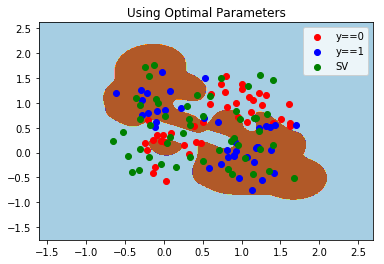

In [89]:
draw_decision_boundary(svc_with_optimal_params, test_input, test_labels, 'Using Optimal Parameters')

## c

* Compared to standard parameters, we got a similar number of support vectors but worse generalization performance. From above graph, we could see obvious overfitting. That's why we got worse performance.

SVM with standard parameters but C=C/4 using RBF kernel: acc is 0.825000, num of SVs: 52


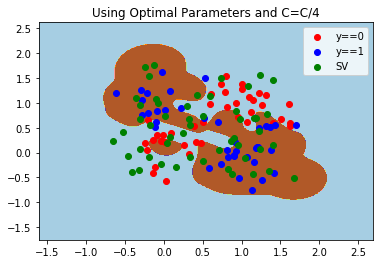

In [87]:
svc_with_C_div_4, acc = svm_predict(train_input, train_labels, c_p=optimal_params[0]/4, gamma_p=optimal_params[1])
print ("SVM with standard parameters but C=C/4 using RBF kernel: acc is %f, num of SVs: %d" % 
       (acc, len(svc_with_C_div_4.support_vectors_)))
draw_decision_boundary(svc_with_C_div_4, test_input, test_labels, 'Using Optimal Parameters and C=C/4')

SVM with standard parameters but gamma=gamma/4 using RBF kernel: acc is 0.825000, num of SVs: 24


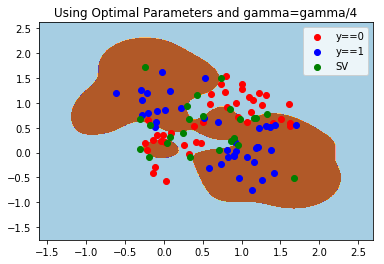

In [86]:
svc_with_gamma_div_4, acc = svm_predict(train_input, train_labels, c_p=optimal_params[0], gamma_p=optimal_params[1]/4)
print ("SVM with standard parameters but gamma=gamma/4 using RBF kernel: acc is %f, num of SVs: %d" % 
       (acc, len(svc_with_gamma_div_4.support_vectors_)))
draw_decision_boundary(svc_with_gamma_div_4, test_input, test_labels, 'Using Optimal Parameters and gamma=gamma/4')

* As we could see from above 2 graphs, if dividing C by 4, we did not see any difference (while from the manual we know that smaller C will give a smoother boundary since higher misclassification tolerance). However, if we diveding gamma by 4, the number of support vectors approximately reduced by half and those left support vectors are closer to the decision boundary compared to the eliminated ones. This is because that smaller gamma gives the less influence to the raining points, which means training points will not be affected by its neighbours too much. And the decision boundary becomes smoother while using smaller gamma.